## Loading in dataset for checking templates

In [1]:
import seaborn as sns
import pandas as pd

# Loading the dataset
df = sns.load_dataset('titanic')


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Summary Statistics to understand the dataset

In [2]:
print('Dataset Overview\n', df.head()) # Display first few rows of the dataset
print('Dataset Shape\n', df.shape) # Displays the shape of the dataset (rows, columns)
print('Dataset Info\n', df.info()) # Displays info about the dataset
print('Dataset Summary\n', df.describe()) # Displays summary statistics about the dataset
print('Dataset Missing Values\n', df.isnull().sum()) # Displays the missing values in the dataset - totals per column


Dataset Overview
    survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True  
Dataset Shape
 (891, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       ----------

### Dropping uneeded columns - can skip if all columns are useful.

In [3]:
df = df.drop(columns=['embarked', 'embark_town', 'deck'], axis=1)

print(df.head())

   survived  pclass     sex   age  sibsp  parch     fare  class    who  \
0         0       3    male  22.0      1      0   7.2500  Third    man   
1         1       1  female  38.0      1      0  71.2833  First  woman   
2         1       3  female  26.0      0      0   7.9250  Third  woman   
3         1       1  female  35.0      1      0  53.1000  First  woman   
4         0       3    male  35.0      0      0   8.0500  Third    man   

   adult_male alive  alone  
0        True    no  False  
1       False   yes  False  
2       False   yes   True  
3       False   yes  False  
4        True    no   True  


## Missing Value Handling

In [4]:
from sklearn.impute import SimpleImputer

def impute_missing_values(df, strategy='mean', fill_value=None, columns=None):
  '''
  A function to impute missing values in the dataset.

  Parameters:
    df: The pandas dataframe
    strategy: Type-str, Default-'mean', Options - mean, median, most_frequent, constant
    fill_value: Only used with strategy constant - fills the missing values with the fill value
    columns: Type-list, Default-None, Imputes all columns if value is None, or list of selected columns

  Returns:
    DataFrame with the imputed values
  '''

  if columns is None:
    columns = df.columns # The imputer is applied to all columns in the dataset

  imputer = SimpleImputer(strategy=strategy, fill_value=fill_value) # Initializing the imputer
  df[columns] = imputer.fit_transform(df[columns]) # Applying the imputer to selected columns

  return df


### Testing the imputer

In [5]:
# Checking missing values
print("Missing Values Before Imputation:\n", df.isnull().sum())

# Applying imputation on 'age'
df = impute_missing_values(df, strategy="mean", columns=['age']) # Only applyng to age as can drop the rest

# Checking missing values
print("Missing Values After Imputation:\n", df.isnull().sum())


Missing Values Before Imputation:
 survived        0
pclass          0
sex             0
age           177
sibsp           0
parch           0
fare            0
class           0
who             0
adult_male      0
alive           0
alone           0
dtype: int64
Missing Values After Imputation:
 survived      0
pclass        0
sex           0
age           0
sibsp         0
parch         0
fare          0
class         0
who           0
adult_male    0
alive         0
alone         0
dtype: int64


## Encoding Categorical Variables

In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

def encode_categorical(df, columns, method='onehot'):
    '''
    Encoding categorical (text) variables in a Dataframe.

    Parameters:
      df: The pandas dataframe
      columns: Type-list of str, The list of columns to encode
      method: Type-str, Default-'onehot', Options - onehot, label

    Info:
      onehot encoding - Used on nominal data where is there is no inherent order or ranking between the categories (e.g., colors, countries)
      label encoding - Used on ordinal data where the categories have natural ordering (e.g., "Low", "Medium", "High")

    Returns:
      Dataframe with encoded variables
    '''

    if method == 'onehot':
        for col in columns:
            encoder = OneHotEncoder(sparse_output=False, drop='first') # Converting the spare matrix which is outputted by default into a dense array. Drop first to avoid multicolinearity which undermines the statistical significance of an independent variable
            encoded = encoder.fit_transform(df[[col]]) # The encoded column
            encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out([col]), index=df.index)
            df = pd.concat([df, encoded_df], axis=1) # Appending the encoded columns to the df
            df.drop(columns=col, inplace=True) # Dropping the original columns
        
    elif method == 'label':
        for col in columns:
            encoder = LabelEncoder()
            df[col] = encoder.fit_transform(df[col]) # Replacing the original columns with the label encoded values
            
    return df
        

### Testing the encoder

In [11]:
# Encoding the nominal columns with onehot encoding
df = encode_categorical(df, columns=['sex', 'adult_male', 'who', 'alone'], method='onehot')
print("After OneHot Encoding:\n", df.head())

# Encoding the ordinal column with label encoding
df = encode_categorical(df, columns=['class'], method='label')
print("\nAfter Label Encoding:\n", df.head())


After OneHot Encoding:
    survived  pclass   age  sibsp  parch     fare  class alive  sex_male  \
0         0       3  22.0      1      0   7.2500  Third    no       1.0   
1         1       1  38.0      1      0  71.2833  First   yes       0.0   
2         1       3  26.0      0      0   7.9250  Third   yes       0.0   
3         1       1  35.0      1      0  53.1000  First   yes       0.0   
4         0       3  35.0      0      0   8.0500  Third    no       1.0   

   adult_male_True  who_man  who_woman  alone_True  
0              1.0      1.0        0.0         0.0  
1              0.0      0.0        1.0         0.0  
2              0.0      0.0        1.0         1.0  
3              0.0      0.0        1.0         0.0  
4              1.0      1.0        0.0         1.0  

After Label Encoding:
    survived  pclass   age  sibsp  parch     fare  class alive  sex_male  \
0         0       3  22.0      1      0   7.2500      2    no       1.0   
1         1       1  38.0      1 

## Plotting a Correlation Matrix to show relationships between the features and target variable

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_matrix(df, target_column=None):
    '''
    Plots a correlation matrix for the dataframe to show feature to target correlations.

    Parameters:
      df: The pandas Dataframe
      target_column = Type-str, Highlights correlation with the target column

    Returns:
      None - Displays the heatmap
    '''

    numeric_df = df.select_dtypes(include=['number'])  # Use only numeric columns
    corr_matrix = numeric_df.corr()

    plt.figure(figsize=(10, 8)) # Can adjust if needed
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)

    if target_column:
        plt.title(f'Correlation Matrix (highlighting {target_column})')
    else:
        plt.title('Correlation Matrix')

    plt.show()

## Automated feature removal based on correlation - optional

In [16]:
def remove_low_correlation_features(df, target_column, threshold=0.1):
    '''
    Removing the features which have low correlation to the target variable.

    Parameters:
      df: The pandas Dataframe
      target_column: Type-str, The target value that is being compared against
      threshold: Type-float, Default-0.1, Absolute correlation threshold below which features are removed.

    Returns:
      Dataframe with low correlation features removed.
    '''

    df = df.select_dtypes(include=['number']) # Filtering numeric columns only

    corr_with_target = df.corr()[target_column].abs() # Absolute correlation with the target
    low_corr_features = corr_with_target[corr_with_target < threshold].index.tolist()

    print(f'Features to drop (correlation with {target_column} < {threshold}): {low_corr_features}')
    return df.drop(columns=low_corr_features), corr_with_target

### Testing the correlation matrix and feature removal

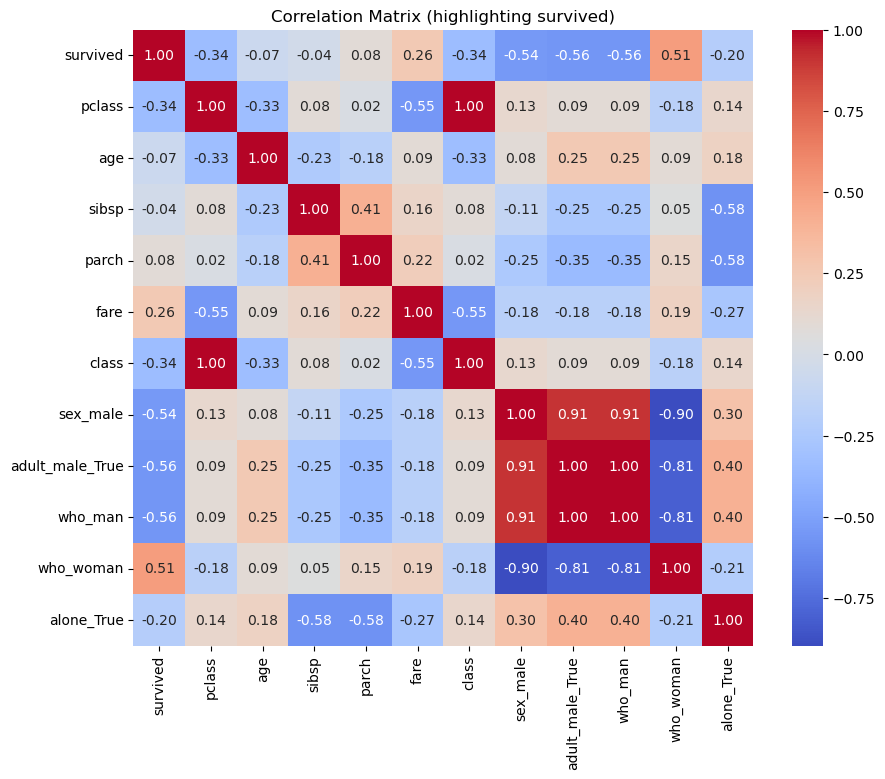

Features to drop (correlation with survived < 0.1): ['age', 'sibsp', 'parch']
   survived  pclass     fare  class  sex_male  adult_male_True  who_man  \
0         0       3   7.2500      2       1.0              1.0      1.0   
1         1       1  71.2833      0       0.0              0.0      0.0   
2         1       3   7.9250      2       0.0              0.0      0.0   
3         1       1  53.1000      0       0.0              0.0      0.0   
4         0       3   8.0500      2       1.0              1.0      1.0   

   who_woman  alone_True  
0        0.0         0.0  
1        1.0         0.0  
2        1.0         1.0  
3        1.0         0.0  
4        0.0         1.0  


In [17]:
# Plotting the correlation matrix to inspect relationships
plot_correlation_matrix(df, target_column='survived')

# Removing features with low correlation to the target - Optional
df, corr_with_target = remove_low_correlation_features(df, target_column='survived', threshold=0.1)

print(df.head())

## Scaling Data

In [18]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

def scale_data(df, scaler_type="standard", columns=None):
  '''
  Scaling numeric data within the dataframe - most likely used on feature (X) values.

  Parameters:
    df: The pandas Dataframe
    scaler_type: Type-str, Default-'standard', Options - standard, minmax, robust

    Info:
      standard - Scales features to have a mean of 0 and standard deviation of 1 (standardization). Useful for normally distributed data.
      minmax - Scales features to a range of [0, 1] or a custom range. Sensitive to outliers but preserves data distribution.
      robust - Scales features using the median and interquartile range (IQR). Less sensitive to outliers compared to standard or minmax scaling.

  Returns:
    The scaled dataframe
  '''

  scalers = {
      'standard': StandardScaler(),
      'minmax': MinMaxScaler(),
      'robust': RobustScaler()
  }
  scaler = scalers.get(scaler_type)


  if columns is None:
    columns = df.select_dtypes(include=['number']).columns # Default to numeric columns if no specific columns are provided


  scaled_df = pd.DataFrame(scaler.fit_transform(df[columns]), columns=columns)


  return scaled_df


### Testing the scaler

In [20]:
# Creating the features dataframe - dropping target value plus columns with missing values and non numeric type for simplicity
X = df.drop(columns=['survived'], axis=1)
# Creating the target dataframe for future use
y = df['survived']
print(X.info())
# Displaying unscaled values
print('Unscaled X Values\n', X.head())

# Applying the scaler on the target columns
X = scale_data(X)

# Displaying scaled values
print('\nScaled X Values\n', X.head())
print('\nFeatures Data Info\n', X.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pclass           891 non-null    int64  
 1   fare             891 non-null    float64
 2   class            891 non-null    int32  
 3   sex_male         891 non-null    float64
 4   adult_male_True  891 non-null    float64
 5   who_man          891 non-null    float64
 6   who_woman        891 non-null    float64
 7   alone_True       891 non-null    float64
dtypes: float64(6), int32(1), int64(1)
memory usage: 52.3 KB
None
Unscaled X Values
    pclass     fare  class  sex_male  adult_male_True  who_man  who_woman  \
0       3   7.2500      2       1.0              1.0      1.0        0.0   
1       1  71.2833      0       0.0              0.0      0.0        1.0   
2       3   7.9250      2       0.0              0.0      0.0        1.0   
3       1  53.1000      0       0.0            